In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow

import pandas as pd 
import numpy as np
import tensorflow as tf
from tensorflow import keras
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from keras.preprocessing.sequence import pad_sequences

import xml.etree.ElementTree as ET
import io

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# model imports

from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping
from keras.layers import Conv1D, MaxPool1D, Dense, Flatten, Reshape, Input, Dropout
from keras.layers import Embedding, LSTM, SpatialDropout1D, Bidirectional, Add, Average
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix
from keras.layers import Concatenate,RepeatVector,InputLayer,TimeDistributed, Layer
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
import matplotlib.pyplot as plt

In [ ]:
stop_words = set(stopwords.words("english"))
lem = WordNetLemmatizer()

### Preprocessing

In [ ]:
# converting xml to data frame
# tree = ET.parse("restaurants_trial_english_sl.xml")
# tree = ET.parse("ABSA16_Restaurants_Train_SB1_v2.xml")
train_root = ET.parse("/content/drive/MyDrive/IIIT-H/SMAI/ABSA16_Restaurants_Train_SB1_v2.xml").getroot()
# train_root = ET.parse("/content/drive/MyDrive/smai project/ABSA16_Restaurants_Train_SB1_v2.xml").getroot()
test_root = ET.parse("/content/drive/MyDrive/IIIT-H/SMAI/EN_REST_SB1_TEST.xml.gold").getroot()
# test_root = ET.parse("/content/drive/MyDrive/smai project/EN_REST_SB1_TEST.xml").getroot()

In [ ]:
# Glove embedding

embed_dict = {}
# with open('/content/drive/MyDrive/smai3/glove.6B/glove.6B.300d.txt','r') as f:
with open('/content/drive/MyDrive/IIIT-H/SMAI/glove/glove.6B.300d.txt','r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    embed_dict[word]=vector

embed_dict['oov'] = np.zeros(300)

In [ ]:
# converting to dataframe

def convert_to_df(root):

  corpus = []
  row_items = []
  max_len = 0
  sum = 0
  n = 0

  for review_item in root.iter('Review'):
    for sent_item in review_item.iter('sentence'):
      for opinion_item in sent_item.iter('Opinion'):
        single_row_data = []
        review_id = review_item.attrib.get('rid')
        sentence_id = sent_item.attrib.get('id').split(':')[1]
        category = opinion_item.attrib.get('category')
        entity = category.split('#')[0]
        attribute = category.split('#')[1]
        txt = sent_item.find('text').text
        corpus.append(txt)
        polarity = opinion_item.attrib.get('polarity')

        if (len(txt) > max_len):
          max_len = len(txt)
        
        sum += len(txt)
        n+=1
        single_row_data.append(review_id)
        single_row_data.append(sentence_id)
        single_row_data.append(txt)
        single_row_data.append(entity)
        single_row_data.append(attribute)
        single_row_data.append(polarity)

        row_items.append(single_row_data)

  avg_len  = int(sum/n)

  doc_df = pd.DataFrame(row_items, columns=['review_id', 'sentence_id', 'text', 'entity', 'attribute', 'polarity'])
  return doc_df,avg_len

In [ ]:
# finding maximum number of sentences in each review

def find_max_sentences(doc_df):

  review_id_indices = {}
  review_ids_all = list(doc_df['review_id'])
  review_id_list = list(set(doc_df['review_id']))
  max_sentences = 0
  for i in review_id_list:
    l = []
    l.append(review_ids_all.index(i))
    last_index_pos = len(review_ids_all) - review_ids_all[::-1].index(i) - 1 
    l.append(last_index_pos)
    review_id_indices[i] = l
    if (max_sentences < l[1]-l[0]+1):
      max_sentences = l[1]-l[0]+1
  
  return max_sentences,review_id_indices

In [ ]:
df_train, avg_words_train = convert_to_df(train_root)
df_test, avg_words_test = convert_to_df(test_root)
print("AVERGAE NUMBER OF WORDS TRAIN:",avg_words_train)
print("AVERGAE NUMBER OF WORDS TEST:",avg_words_test)

AVERGAE NUMBER OF WORDS TRAIN: 77
AVERGAE NUMBER OF WORDS TEST: 83


In [ ]:
max_sentences_train,review_id_indices_train = find_max_sentences(df_train)
max_sentences_test,review_id_indices_test = find_max_sentences(df_test)
print("MAX NUMBER OF SENTENCES IN REVIEW IN TRAIN:",max_sentences_train)
print("MAX NUMBER OF SENTENCES IN REVIEW IN TEST:",max_sentences_test)

MAX NUMBER OF SENTENCES IN REVIEW IN TRAIN: 44
MAX NUMBER OF SENTENCES IN REVIEW IN TEST: 29


In [ ]:
df_train.head()

,review_id,sentence_id,text,entity,attribute,polarity
0,1004293,0,Judging from previous posts this used to be a ...,RESTAURANT,GENERAL,negative
1,1004293,1,"We, there were four of us, arrived at noon - t...",SERVICE,GENERAL,negative
2,1004293,2,"They never brought us complimentary noodles, i...",SERVICE,GENERAL,negative
3,1004293,3,The food was lousy - too sweet or too salty an...,FOOD,QUALITY,negative
4,1004293,3,The food was lousy - too sweet or too salty an...,FOOD,STYLE_OPTIONS,negative


In [ ]:
df_test.head()

,review_id,sentence_id,text,entity,attribute,polarity
0,en_BlueRibbonSushi_478218171,0,Yum!,FOOD,QUALITY,positive
1,en_BlueRibbonSushi_478218171,1,Serves really good sushi.,FOOD,QUALITY,positive
2,en_BlueRibbonSushi_478218171,2,Not the biggest portions but adequate.,FOOD,STYLE_OPTIONS,neutral
3,en_BlueRibbonSushi_478218171,3,Green Tea creme brulee is a must!,FOOD,QUALITY,positive
4,en_BlueRibbonSushi_478218171,4,Don't leave the restaurant without it.,FOOD,QUALITY,positive


In [ ]:
MAX_SENT_LENGTH = max(avg_words_train,avg_words_test)    #83
MAX_SENTS = max(max_sentences_train,max_sentences_test)  #44
ENTITY_COUNT = len(set(df_train['entity']))       #7
ATTRIBUTES_COUNT = len(set(df_train['attribute']))   #6
reviews_count_train = len(set(df_train['review_id']))
reviews_count_test = len(set(df_test['review_id']))

In [ ]:
# padding doc_df based on the maximum number of sentences

def pad_dataframe(doc_df,review_id_indices):

  for key,index in review_id_indices.items():
    s = index[0]
    e = index[1]
    len_s = e-s+1

    if(MAX_SENTS > len_s):
      for i in range(MAX_SENTS - len_s):
        series_obj = pd.Series([key,45, 'oov', -1,-1 ,-1], index=doc_df.columns)
        doc_df = doc_df.append(series_obj,ignore_index=True)

  doc_df = doc_df.sort_values(by=['review_id','sentence_id'],ascending=False)
  doc_df.reset_index(inplace = True, drop = True)

  return doc_df

In [ ]:
# tokenizing and removing the stop words

def tokenize_removestopwords(doc_df):

  for x in range(doc_df.shape[0]):
    statement = re.sub('[^a-zA-Z]', ' ', doc_df['text'][x]) # Removing all numbers and special characters
    statement = statement.lower() # Converting uppercase to lowercase
    statement = word_tokenize(statement)
    
    filtered_stopwords = []
    for i in statement:
      if i not in stop_words: 
        filtered_stopwords.append(i)
    statement = filtered_stopwords
    
    lem_words = []
    for i in statement:
        lem_words.append(lem.lemmatize(i,"v"))
    statement = lem_words
    
    doc_df['text'][x] = statement

  return doc_df


In [ ]:
df_train = pad_dataframe(df_train,review_id_indices_train)
df_test= pad_dataframe(df_test,review_id_indices_test)

In [ ]:
df_train = tokenize_removestopwords(df_train)
df_test = tokenize_removestopwords(df_test)

In [ ]:
df_train.head()

,review_id,sentence_id,text,entity,attribute,polarity
0,Z#9,7,"[prob, return, great, din, experience, try, at...",RESTAURANT,GENERAL,negative
1,Z#9,7,"[prob, return, great, din, experience, try, at...",RESTAURANT,GENERAL,positive
2,Z#9,6,"[really, end, pay, restaurant, food]",RESTAURANT,PRICES,negative
3,Z#9,6,"[really, end, pay, restaurant, food]",AMBIENCE,GENERAL,neutral
4,Z#9,6,"[really, end, pay, restaurant, food]",FOOD,QUALITY,negative


In [ ]:
df_test.head()

,review_id,sentence_id,text,entity,attribute,polarity
0,en_StackRestaurant__Bar_478538242,7,"[leave, room, dessert]",FOOD,QUALITY,positive
1,en_StackRestaurant__Bar_478538242,6,"[great, bottle, wine]",DRINKS,QUALITY,positive
2,en_StackRestaurant__Bar_478538242,5,"[caesar, salad, superb]",FOOD,QUALITY,positive
3,en_StackRestaurant__Bar_478538242,4,"[seabass, lobster, risotto, best]",FOOD,QUALITY,positive
4,en_StackRestaurant__Bar_478538242,3,"[appetizer, oyster, lobster, crab, small, size...",FOOD,QUALITY,positive


In [ ]:
def get_indices(df):

  sent_indices={}
  for i in range(len(df)):
    key = df['review_id'][i]
    if key not in sent_indices:
      sent_indices[key] =[i,-1]
    elif(sent_indices[key][1] == -1):
      if(df['sentence_id'][i] == 45):
        sent_indices[key][1] = i-1
  
  sent_indices = sorted(sent_indices.items(),key=lambda x:x[1][0])
  return sent_indices

In [ ]:
sent_indices = get_indices(df_test)

In [ ]:
# creating the vocabulary
def add_to_vocab(doc_df,c,vocab):
  for j in range(doc_df.shape[0]):
    statement = doc_df['text'][j]
    for i in statement:
      if i not in vocab:
        vocab[i] = c
        c += 1
  return vocab,c

In [ ]:
c = 0
vocab = {}
vocab['oov'] = 0
vocab,c_train = add_to_vocab(df_train,c,vocab)

In [ ]:
def labelEncode(data):
  le = LabelEncoder()
  le.fit(data)
  return le.transform(data)  

In [ ]:
len(df_train['text'])

15356

In [ ]:
def embed(doc_df,review_id_indices,max_sentences,vocab,avg_len,cnt):

  for x in range(doc_df.shape[0]):
    preprocessed_statement = doc_df['text'][x]
    for j in range(len(preprocessed_statement)):

      if(preprocessed_statement[j] not in vocab.keys()):
        preprocessed_statement[j] = vocab['oov']
      else:
        preprocessed_statement[j] = vocab[preprocessed_statement[j]]

  
  padded = pad_sequences(doc_df['text'],padding="post",truncating="post",maxlen=avg_len)
  
  for i in range(len(padded)):
    doc_df['text'][i] = padded[i]

  entities_data = []
  attributes_data = []
  polarities_data = []

  entities=[]
  attributes = []
  polarity =[]
  reviews=[]

  # get max len of entity
  for i in range(len(doc_df)) :
    entities_data.append(doc_df.loc[i, "entity"])
    attributes_data.append(doc_df.loc[i, "attribute"])
    polarities_data.append(doc_df.loc[i, "polarity"])
    reviews.append(doc_df.loc[i,'text'])


  entities = labelEncode(entities_data)
  attributes = labelEncode(attributes_data)
  polarity = labelEncode(attributes_data)
  # test_x = labelEncode(test_x_data)


  for i in range(len(doc_df)) :
    doc_df.at[i, 'entity'] = entities[i]
    doc_df.at[i, 'attribute'] = attributes[i]
    # doc_df.at[i, 'polarity'] = test_x[i]

  doc_df.tail()

  
  kk = np.array(polarities_data)
  jj = kk.reshape(-1,1)
  onehot_encoder = OneHotEncoder(sparse=False)
  onehot_encoded = onehot_encoder.fit_transform(jj)
  # onehot_encoded = labelEncode(jj)
  
  embed_matrix = {}
  embedding_matrix = []

  for word in vocab:
    if word in embed_dict:
      embed_matrix[vocab[word]] = np.array(embed_dict[word])
    else:
      embed_matrix[vocab[word]] = np.zeros(300)

  embed_matrix[0] = np.zeros(300)
  for value in embed_matrix:
    embedding_matrix.append(embed_matrix[value])

  embedding_matrix = np.array(embedding_matrix)
  
  entities= np.array(entities).reshape(cnt,MAX_SENTS,1)
  attributes = np.array(attributes).reshape(cnt,MAX_SENTS,1)

  test_x_1 = onehot_encoded.reshape(cnt,MAX_SENTS,4)
  train_x = np.array(reviews)
  train_x = train_x.reshape(cnt,MAX_SENTS,MAX_SENT_LENGTH)
  # print(train_x.shape,test_x_1.shape)
  return doc_df,train_x,test_x_1,embedding_matrix,entities,attributes

In [ ]:
df_train,x_train,y_train,embedding_matrix_train,entities_train,attributes_train = embed(df_train,review_id_indices_train,MAX_SENTS,vocab,MAX_SENT_LENGTH,reviews_count_train)
df_test,x_test,y_test,embedding_matrix_test,entities_test,attributes_test = embed(df_test,review_id_indices_test,MAX_SENTS,vocab,MAX_SENT_LENGTH,reviews_count_test)

In [ ]:
y_train.shape

(349, 44, 4)

In [ ]:
y_test.shape

(90, 44, 4)

In [ ]:
df_train.head()

,review_id,sentence_id,text,entity,attribute,polarity
0,Z#9,7,"[0, 1, 2, 3, 4, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,1,negative
1,Z#9,7,"[0, 1, 2, 3, 4, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,1,positive
2,Z#9,6,"[7, 8, 9, 10, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",5,3,negative
3,Z#9,6,"[7, 8, 9, 10, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",1,1,neutral
4,Z#9,6,"[7, 8, 9, 10, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",3,4,negative


### MODEL

In [ ]:
# setting lengths
MAX_NB_WORDS = len(vocab)-1
EMBEDDING_DIM = 300

In [149]:
def build_model():

  sentence_input = Input(shape=(MAX_SENT_LENGTH))

  embedding_layer = Embedding(MAX_NB_WORDS,
                            EMBEDDING_DIM,
                            input_length=MAX_SENT_LENGTH,
                            trainable=False,
                            mask_zero=True,
                            weights=[embedding_matrix_train])
  
  embedded_sequences = embedding_layer(sentence_input)
  Drop_out_layer = Dropout(rate=0.5)(embedded_sequences)

  lstm_last, last_hidden_f, last_cell_f, last_hidden_b, last_cell_b = Bidirectional(LSTM(200,return_state= True))(Drop_out_layer)
  concatenated_fl_bl = Concatenate(axis=1)([last_hidden_f,last_hidden_b])
  sentEncoder = Model(sentence_input, outputs = concatenated_fl_bl)
  print("============ SENTENCE LEVEL LSTM ============")
  sentEncoder.summary()

  entity_inp_1 = Input(shape=(MAX_SENTS,), name='entity_inp_1')
  attribute_inp_1 = Input(shape=(MAX_SENTS,), name='attribute_inp_1')

  emb_entity = Embedding(ENTITY_COUNT+1, 15,mask_zero=True,trainable=True)(entity_inp_1)
  emb_entity = Dropout(rate=0.5)(emb_entity)

  emb_attribute = Embedding(ATTRIBUTES_COUNT+1, 15,mask_zero=True,trainable=True)(attribute_inp_1)
  emb_attribute = Dropout(rate=0.5)(emb_attribute)

  combined_inp = Average()([emb_entity, emb_attribute])

  review_input = Input(shape=(MAX_SENTS, MAX_SENT_LENGTH))
  review_input = keras.layers.Masking(mask_value=0)(review_input)
  
  review_encoder = TimeDistributed(sentEncoder)(review_input)

  last_hidden_f, last_hidden_b =  tf.split(review_encoder, num_or_size_splits=2, axis=2)

  fl = Concatenate(axis=2)([last_hidden_f,combined_inp])
  bl = Concatenate(axis=2)([last_hidden_b,combined_inp])

  concatenated_fl_bl_aspect = Concatenate(axis=2)([fl,bl])

  review_lstm = Bidirectional(LSTM(200))(concatenated_fl_bl_aspect)
  review_lstm = Dropout(rate=0.5)(review_lstm)

  preds = Dense(MAX_SENTS*4*2)(review_lstm)
  preds = Dense(MAX_SENTS*4, activation='softmax')(preds)
  preds = Reshape((MAX_SENTS, 4))(preds)

  model = Model([review_input,entity_inp_1,attribute_inp_1], preds)
  print("\n\n============ REVIEW LEVEL LSTM ============")
  model.summary()

  return model

In [ ]:
def compile_train(model,x_train,entities_train,attributes_train,y_train):

  opt = tf.keras.optimizers.Adam(clipnorm=0.5)
  model.compile(loss=keras.losses.CategoricalCrossentropy(), 
                      optimizer=opt, 
                      metrics=['accuracy'])
  
  early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3,
        verbose=1,
        mode="max",
        restore_best_weights=True, 
     )
  
  history = model.fit([x_train,entities_train,attributes_train],
                    y_train,
                    batch_size = 10,epochs = 50,
                    verbose = 1,
                    callbacks=[early_stopping],
                    validation_split=0.2)
  
  return history

In [ ]:
def plot_train_test_accuracy(history):

  fig, (ax1, ax2) = plt.subplots(1, 2,figsize =(17,5))
  ax1.plot(history.history['accuracy'], label='accuracy')
  ax1.plot(history.history['val_accuracy'], label = 'val_accuracy')
  ax1.set_title('Accuracy')
  ax1.set(xlabel='Epoch', ylabel='Accuracy')
  ax1.legend(loc='lower right')


  ax2.plot(history.history['val_loss'], label = 'val_loss')
  ax2.plot(history.history['loss'], label = 'loss')
  ax2.set_title('Loss')
  ax2.set(xlabel='Epoch', ylabel='Loss')
  ax2.legend(loc='lower right')


In [ ]:
def find_label(y):

  y_test=[]
  for i in y:
    l=[]
    for j in i:
        y_test.append(np.argmax(j))

  return y_test 

In [ ]:
def predict_label(model,y_test):

  y_pred = model.predict([x_test,entities_test,attributes_test])
  y_actual = find_label(y_test)

  y_predicted = find_label(y_pred)

  return y_actual,y_predicted

In [ ]:
def display_metrics(y_test,y_pred):
  print("Accuracy on test data:" , accuracy_score(y_test, y_pred))
  print("F1-score:",f1_score(y_test, y_pred,average=None))
  print(multilabel_confusion_matrix(y_test, y_pred))

============ SENTENCE LEVEL LSTM ============
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 83)]         0           []                               
                                                                                                  
 embedding_15 (Embedding)       (None, 83, 300)      742800      ['input_12[0][0]']               
                                                                                                  
 dropout_20 (Dropout)           (None, 83, 300)      0           ['embedding_15[0][0]']           
                                                                                                  
 bidirectional_10 (Bidirectiona  [(None, 400),       801600      ['dropout_20[0][0]']             
 l)                              (None, 200),

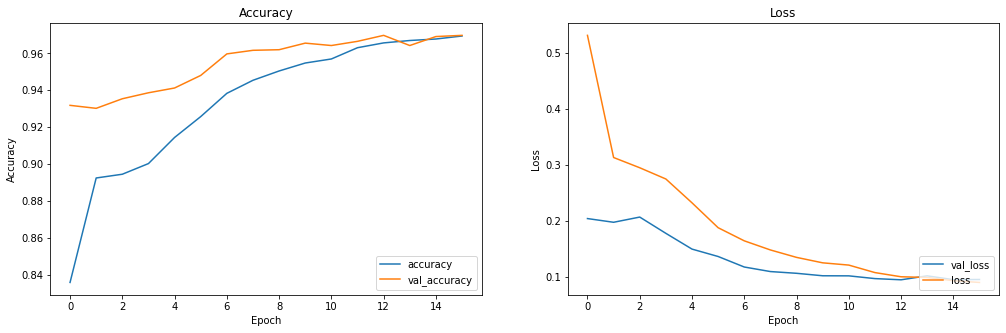

In [ ]:
model = build_model()
history = compile_train(model,x_train,entities_train,attributes_train,y_train)
plot_train_test_accuracy(history)

In [ ]:
y_actual,y_predicted = predict_label(model,y_test)
display_metrics(np.array(y_actual),np.array(y_predicted))

Accuracy on test data: 0.9404040404040404
F1-score: [0.9838198  0.67312349 0.         0.83520276]
[[[ 757  102]
  [   0 3101]]

 [[3686   70]
  [  65  139]]

 [[3916    0]
  [  44    0]]

 [[3285   64]
  [ 127  484]]]
